In [13]:
import sys, time, os, asyncio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time
import astropy.units as u
from lsst_efd_client import EfdClient
from lsst.summit.utils.efdUtils import makeEfdClient, getEfdData
from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState
from tqdm import tqdm
from datetime import datetime

%matplotlib inline
%load_ext lab_black
%load_ext autoreload
%autoreload 2

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
def add_timestamp(data):
    """
    Adds a correct timestamp column in UTC format to the provided data if
    not present.

    Parameters
    ----------
    data : DataFrame
        The data to which the timestamp will be added.

    Returns
    -------
    DataFrame
        The data with the added 'snd_timestamp_utc' column.
    """
    if "snd_timestamp_utc" not in data.columns:
        data["snd_timestamp_utc"] = Time(
            data["private_sndStamp"], format="unix_tai"
        ).unix
    return data


def get_data(events_frame, client_usdf, client_idf, train=False):
    table_dict = {
        "m1m3_hp_actuator": "lsst.sal.MTM1M3.hardpointActuatorData",
        # "m1m3_hp_monitor": "lsst.sal.MTM1M3.hardpointMonitorData",
        # "mtmount_elevation": "lsst.sal.MTMount.elevation",
        # "mtmount_azimuth": "lsst.sal.MTMount.azimuth",
        # "m1m3_ims": "lsst.sal.MTM1M3.imsData"
    }
    query_dict = {}
    for key in table_dict.keys():
        query_dict[key] = []
    for j, time in tqdm(enumerate(events_frame["time"])):
        event_time = Time(events_frame["time"][j], format="unix")
        if event_time < datetime(2023, 11, 28):
            client = client_idf
        else:
            client = client_usdf
        # slew = eventMaker.findEvent(Time(events_frame["time"][j], format="unix"))
        # if slew.blockInfos is None:
        #     block = None
        # else:
        # block = slew.blockInfos.blockNumber

        for key in table_dict.keys():
            query_list = []
            for col in ["private_sndStamp"] + [f"measuredForce{i}" for i in range(6)]:
                hpcols = [col]
                query_list.append(
                    getEfdData(
                        client=client,
                        topic=table_dict[key],
                        columns=hpcols,
                        begin=event_time,
                        end=event_time,
                        prePadding=10,
                        postPadding=10,
                    )
                )
            query = pd.concat(query_list, axis=1)
            if len(query) == 0:
                continue
            query["event_num"] = j
            query["seqNum"] = events_frame["seq_num"][j]
            query["event_time"] = events_frame["time"][j]
            query = add_timestamp(query)

            # query["block"] = block
            query["oscillation_bool"] = 0
            query["delta_time"] = query["snd_timestamp_utc"] - events_frame["time"][j]

            query_dict[key].append(query)
    for key in table_dict.keys():
        query_dict[key] = pd.concat(query_dict[key])
    sorted_keys = sorted(query_dict.keys())
    initial_key = sorted_keys[0]
    merged_df = query_dict[initial_key].sort_index()
    # Define your tolerance for matching
    tolerance = 0.03  # pd.Timedelta('0.03 seconds')

    # Iterate over the remaining DataFrames and merge them
    for key in sorted_keys[1:]:
        merged_df = pd.merge_asof(
            merged_df,
            query_dict[key].sort_index(),
            left_on="snd_timestamp_utc",
            right_on="snd_timestamp_utc",
            tolerance=tolerance,
            direction="nearest",
            suffixes=("", "_" + key),
        )
    merged_df.reset_index(drop=True, inplace=True)

    return merged_df

In [7]:
def get_stats(data):
    keys = [f"measuredForce{n}" for n in range(5)]
    max_val = np.max(data[key])
    min_val = np.min(data[key])
    ptp = np.ptp(data[key])
    before_std = np.std(data.loc[(data["delta_time"].values < 0), key])
    rolling_std = data["measuredForce2"].rolling(100).std()
    max_time = data.iloc[np.argmax(data[key]), :]["delta_time"]
    sel_time = (data["delta_time"] > max_time) & (rolling_std <= before_std + 10)

    if sel_time.sum() > 0:
        duration = np.min(data.loc[sel_time, "delta_time"].values)
        return max_val, min_val, ptp, duration
    else:
        return max_val, min_val, ptp


def get_stats(data):
    # Create an empty DataFrame to store the results
    stats_df = pd.DataFrame(
        columns=["name", "Max Value", "Min Value", "Peak-to-Peak", "Duration"]
    )

    # Define the keys
    keys = [f"measuredForce{n}" for n in range(6)]
    rows = []
    for key in keys:
        sel_0 = data["delta_time"] > 0
        max_val = max(data.loc[sel_0, key], key=abs)
        # min_val = np.min(data.loc[sel_0, key])
        ptp = np.ptp(data.loc[sel_0, key])
        before_std = np.std(data.loc[(data["delta_time"].values < 0), key])
        before_mean = np.mean(data.loc[(data["delta_time"].values < 0), key])
        rolling_std = data[key].rolling(100).std()
        max_time = data.iloc[np.argmax(data[key]), :]["delta_time"]
        sel_time = (
            (data["delta_time"] > max_time) & (rolling_std <= before_std * 2) & sel_0
        )

        # Calculate duration if condition is met
        if sel_time.sum() > 0:
            duration = np.min(data.loc[sel_time, "delta_time"].values)
        else:
            duration = np.nan  # Use NaN for cases where the condition is not met

        # Create a row dictionary and append to the list
        row = {
            "key": key,
            "max": max_val,
            "mean": before_mean,
            "ptp": ptp,
            "duration": duration,
        }
        rows.append(row)
    stats_df = pd.DataFrame(rows)

    return stats_df

In [ ]:
event

In [14]:
client_usdf = EfdClient("usdf_efd")
client_idf = EfdClient("idf_efd")
events_frame = pd.read_csv(
    "./sitcomtn81_data/231121_dynamic_testing_cleaned_oscillations.csv"
)
dayObs = 20231205
events_frame = events_frame  # [events_frame["day_obs"] == dayObs].reset_index()
merged_df = get_data(events_frame, client_usdf, client_idf)

75it [01:04,  1.16it/s]


In [52]:

keep_bool = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
keep_bool += [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
keep_bool += [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
keep_bool += [0, 0, 1, 1, 0, 0, 0, 0, 0, 1]

keep_bool += [1, 1, 0, 0, 1, 1, 0, 0, 0, 0]

keep_bool += [1, 1, 0, 1, 0, 0, 0, 0, 0, 0]
keep_bool += [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
keep_bool += [0, 1, 1, 0, 1]
keep_bool = keep_bool + list(np.ones(len(events_frame) - len(keep_bool)))

In [54]:
events_frame["event_num"] = np.arange(len(events_frame))

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True, False, False,
       False, False, False,  True,  True,  True, False, False,  True,
        True, False, False, False, False,  True,  True, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True, False,  True])

In [61]:
real_events_frame = events_frame[np.array(keep_bool) == 1]

In [90]:
offsets = [-0.1, -1.5, -4, 1, 6, -2, -2, -1.5, 4.5, -2, -2]
offsets += [-2, -2]
real_events_frame.loc[:, "offset"] = offsets + list(
    np.zeros(len(real_events_frame) - len(offsets))
)

In [93]:
real_events_frame.columns

Index(['day_obs', 'seq_num', 'osc_event_num', 'time', 'event_num', 'offset'], dtype='object')

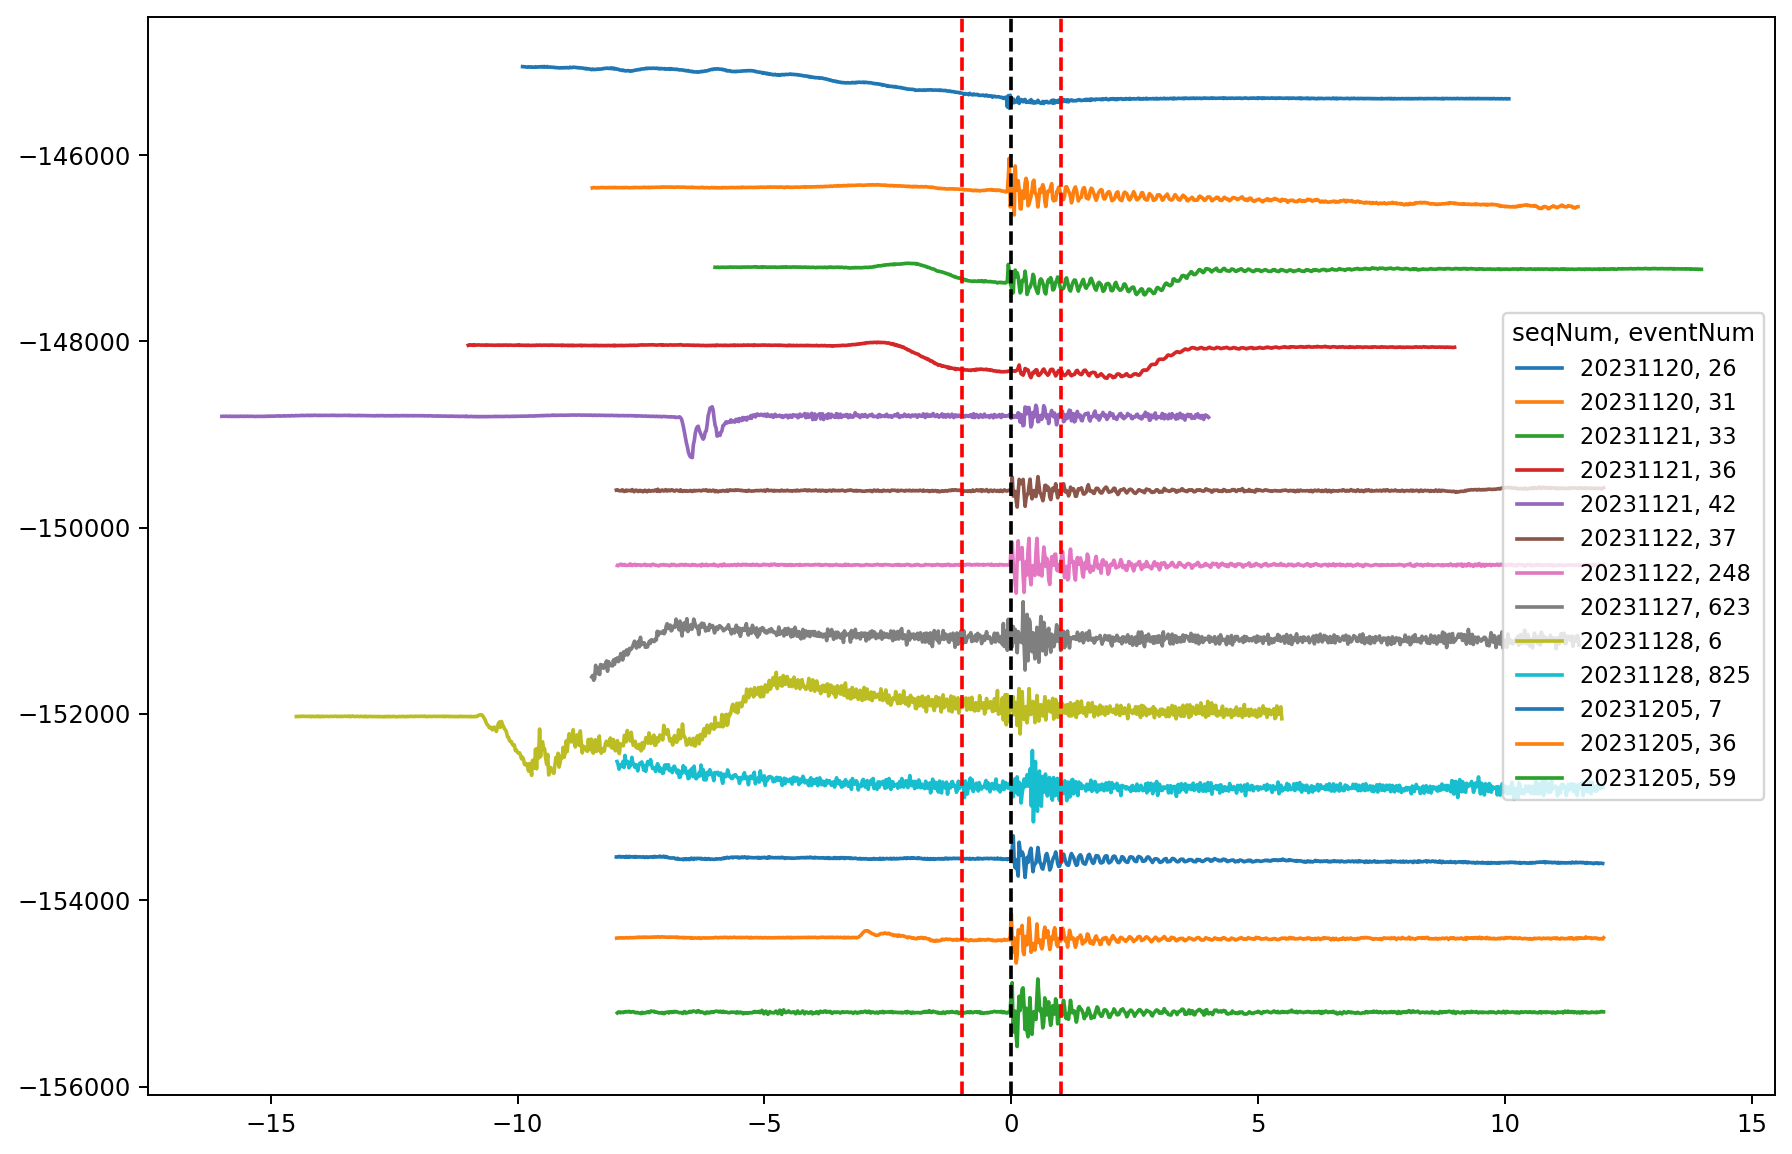

In [95]:
# l = 4  # should be 1 or 4
plt.figure(dpi=175, figsize=(12, 8))
for i in real_events_frame["event_num"]:
    # plt.title(f"{day}, {k}, {l}, {k/l/30}")
    subframe = merged_df.copy()
    subframe = subframe[subframe["event_num"] == i]
    seq_val = np.unique(subframe["seqNum"])
    dayObs = str(
        real_events_frame.loc[real_events_frame["event_num"] == i, "day_obs"].values[0]
    )
    if len(subframe) > 0:
        offset = float(
            real_events_frame.loc[real_events_frame["event_num"] == i, "offset"].values
        )
        plt.plot(
            subframe["delta_time"] - offset,
            subframe["measuredForce2"] - 800 * j,
            label=f"{dayObs}, {seq_val[0]}",
        )
        j += 1
if l == 1:
    plt.legend()
if l == 4:
    plt.legend(fontsize=9.2, loc=7, title="seqNum, eventNum")
plt.axvline(0, c="k", ls="dashed")
plt.axvline(1, c="r", ls="dashed")
plt.axvline(-1, c="r", ls="dashed")
# plt.savefig(f"./sitcomtn81_data/plots/diagnostic_{day}_{k}_{l}_{int(k/l/30)}.png")
# plt.close()

In [15]:
df_list = []
for i in np.unique(merged_df["event_num"]):
    sel = merged_df["event_num"] == i
    stats_df = get_stats(merged_df[sel])
    stats_df["day_obs"] = events_frame["day_obs"].values[i]
    stats_df["seq_num"] = events_frame["seq_num"].values[i]
    # stats_df["elevation_velocity"] = events_frame['elevation_velocity'].values[i]
    stats_df["time"] = events_frame["time"].values[i] + 3
    df_list.append(stats_df)
stats_df = pd.concat(df_list)

In [105]:
# Select data from a given date
eventMaker = TMAEventMaker()
events = eventMaker.getEvents(dayObs)

# Get lists of slew and track events
slews = [e for e in events if e.type == TMAState.SLEWING]

print(f"{len(slews)} slews\nbegin: {slews[0].begin.iso}\nend: {slews[-1].end.iso}")

84 slews
begin: 2023-12-05 19:17:44.823
end: 2023-12-06 08:03:53.610


In [106]:
day_frame = events_frame[events_frame["day_obs"] == dayObs].reset_index()

In [8]:
day_frame.iloc[2]

index            5.800000e+01
day_obs          2.023113e+07
seq_num          9.700000e+01
osc_event_num    3.300000e+01
time             1.701300e+09
Name: 2, dtype: float64

In [107]:
table_dict = {
    # "hp": "lsst.sal.MTM1M3.hardpointActuatorData",
    # "m1m3_hp_monitor": "lsst.sal.MTM1M3.hardpointMonitorData",
    # "el": "lsst.sal.MTMount.elevation",
    "az": "lsst.sal.MTMount.azimuth",
    # "ims": "lsst.sal.MTM1M3.imsData",
    # "fa": "lsst.sal.MTM1M3.forceActuatorData"
    # "fa": "
}
column_dict = {
    # "hp": ["private_sndStamp"] + [f"measuredForce{i}" for i in range(6)],
    # "m1m3_hp_monitor": "lsst.sal.MTM1M3.hardpointMonitorData",
    # "el": ["private_sndStamp", "actualPosition", "actualVelocity", "actualTorque"],
    "az": ["private_sndStamp", "actualPosition", "actualVelocity", "actualTorque"],
    # "ims": ["private_sndStamp"]
    # + [f"{i}Position" for i in ["x", "y", "z"]]
    # + [f"{i}Rotation" for i in ["x", "y", "z"]],
    # "fa": ["private_sndStamp", "forceMagnitude", "fx", "fy", "fz"],
}


def get_data_single_event(t0, client, prePadding=10, postPadding=15):
    query_dict = {}

    for key in table_dict.keys():
        query = getEfdData(
            client,
            table_dict[key],
            columns=column_dict[key],
            begin=t0,
            end=t0,
            prePadding=prePadding,
            postPadding=postPadding,
        )
        query = add_timestamp(query)
        query["delta_time"] = query["snd_timestamp_utc"] - t0.unix
        query_dict[key] = query

    return query_dict

In [84]:
#offset_list = [10, 2, 3.5, 2, 1, 1.5, 2, 4, 9, 4, 1, 1, 8.5, 7.5, -18]

In [108]:
from datetime import datetime

az_point = []
# t0 = Time(datetime(2023, 11, 20, 23, 31, 27))
for index in range(len(offset_list)):
    offset = offset_list[index]
    t0 = Time(events_frame.iloc[index, :]["time"] + offset - 3, format="unix")
    query_dict = get_data_single_event(t0, client, postPadding=42, prePadding=6)
    # slew = eventMaker.findEvent(t0)
    az_val = query_dict["az"]["actualPosition"][
        np.argmin(abs(query_dict["az"]["delta_time"]))
    ]
    print(az_val)
    az_point.append(az_val)

140.999999682092
-2.8562093483967
-57.596649843446
-108.250074964314


IndexError: single positional indexer is out-of-bounds

Text(0.5, 0, 'Azimuth Position [deg]')

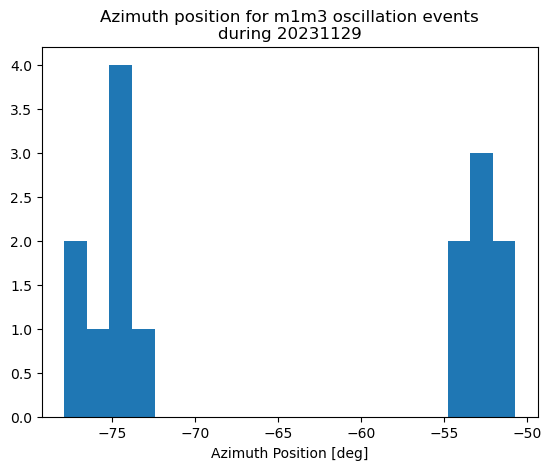

In [97]:
plt.hist(az_point, bins=20)
plt.title("Azimuth position for m1m3 oscillation events\nduring 20231129")
plt.xlabel("Azimuth Position [deg]")

In [72]:
# for index in range(len(events_frame)):
#     t0 = Time(events_frame.iloc[index, :]["time"], format="unix")
#     slew = eventMaker.findEvent(t0)
#     print("")
#     if slew.endReason == 1:
#         reason = "Stopped"
#     if slew.endReason == 1:
#         reason = "Tracking"
#     elif slew.endReason == 3:
#         reason = "Fault"
#     print(f"SeqNum: {slew.seqNum}, end reason: {reason}")
#     print(slew.blockInfos)
#     # if slew.blockInfos is not None:
#     print(slew.seqNum, slew.endReason, slew.blockInfos.blockNumber)
# else:
#     print(slew.seqNum, slew.endReason)

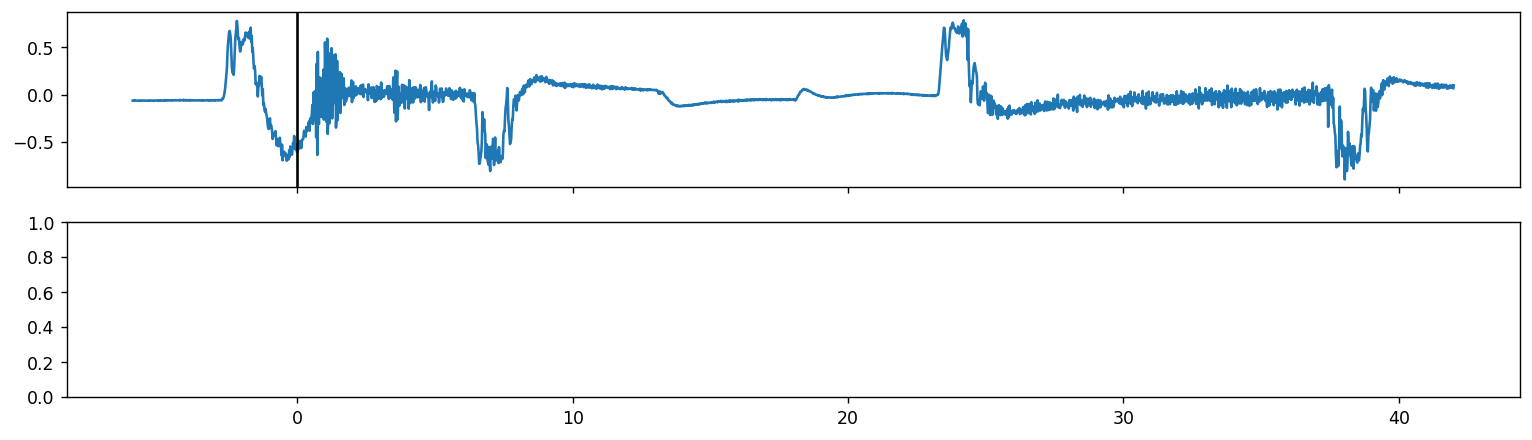

In [81]:
fig, axs = plt.subplots(2, 1, dpi=125, figsize=(15, 4), sharex=True)
ax = axs[0]
dict_key = "hp"
for col in ["measuredForce2"]:
    x = query_dict[dict_key]["delta_time"]
    y = query_dict[dict_key][col] / 1e3
    ax.plot(x, y, label=col)
ax.axvline(0, c="k")

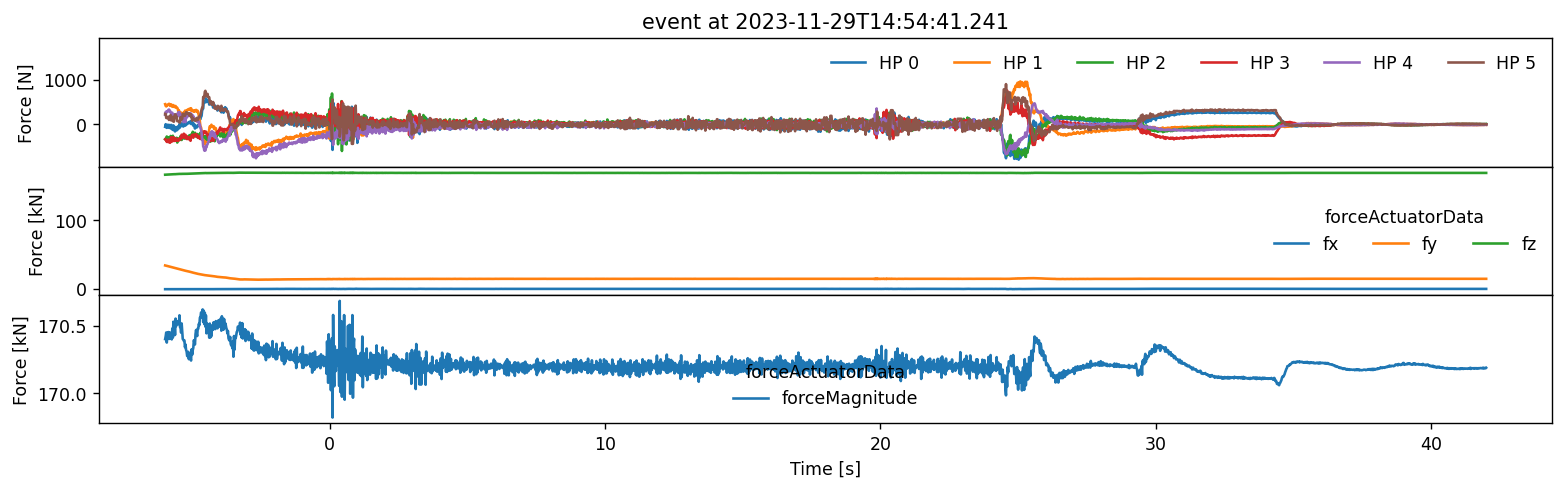

In [36]:
fig, axs = plt.subplots(3, 1, dpi=125, figsize=(15, 4), sharex=True)
ax = axs[0]
ax.set_title(f"event at {t0.isot}")
dict_key = "hp"
ymax = 0
ymin = 0
for fi in range(6):
    x = query_dict[dict_key]["delta_time"]
    y = query_dict[dict_key][f"measuredForce{fi}"]
    ax.plot(x, y, label=f"HP {fi}")
    ymax = max([ymax, 2 * query_dict[dict_key][f"measuredForce{fi}"].max()])
    ymin = min([ymin, 1.2 * query_dict[dict_key][f"measuredForce{fi}"].min()])
ax.legend(ncol=6, facecolor="None", edgecolor="None")
ax.set(ylim=(ymin, ymax), ylabel="Force [N]")

ax = axs[1]
dict_key = "fa"
for col in ["fx", "fy", "fz"]:
    x = query_dict[dict_key]["delta_time"]
    y = query_dict[dict_key][col] / 1e3
    ax.plot(x, y, label=col)
ax.legend(
    ncol=4,
    title="forceActuatorData",
    facecolor="None",
    edgecolor="None",
    loc="right",
)
ax.set(ylabel="Force [kN]")

ax = axs[2]
dict_key = "fa"
for col in ["forceMagnitude"]:  # , "fx", "fy", "fz"]:
    x = query_dict[dict_key]["delta_time"]
    y = query_dict[dict_key][col] / 1e3
    ax.plot(x, y, label=col)
ax.legend(
    ncol=4,
    title="forceActuatorData",
    facecolor="None",
    edgecolor="None",
    loc="lower center",
)
ax.set(ylabel="Force [kN]")

ax.set_xlabel("Time [s]")

plt.subplots_adjust(hspace=0)
# ax.set(ylabel="position\n[deg]")

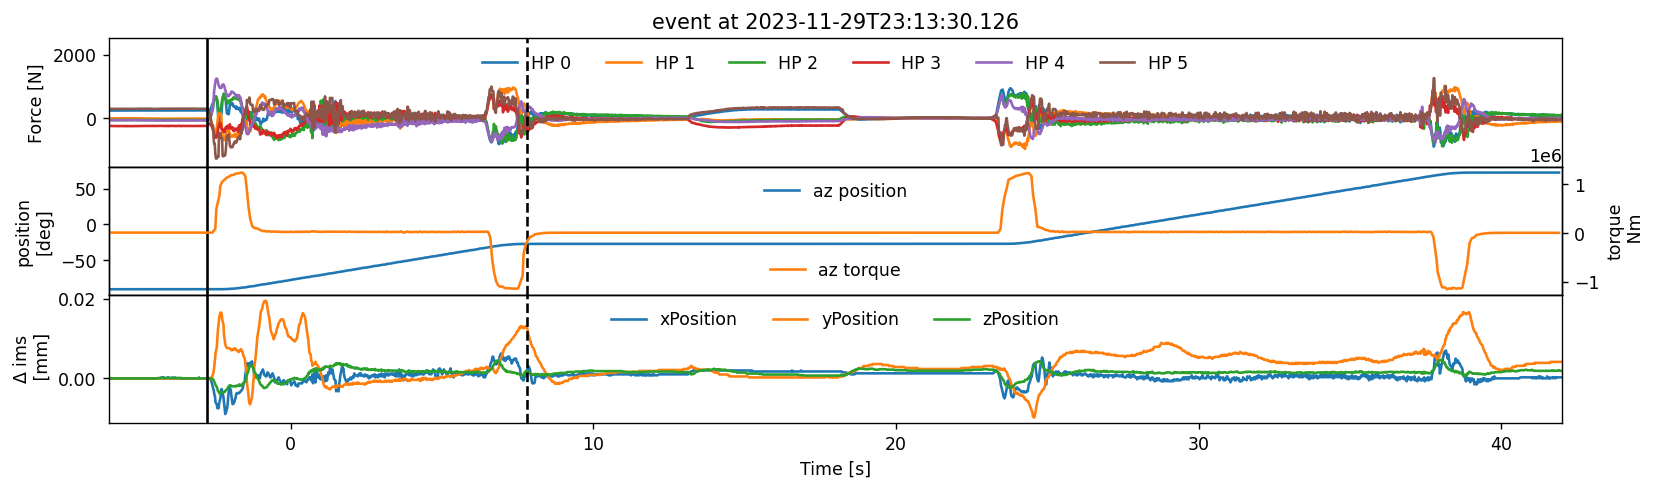

In [82]:
fig, axs = plt.subplots(3, 1, dpi=125, figsize=(15, 4), sharex=True)
ax = axs[0]
ax.set_title(f"event at {t0.isot}")
dict_key = "hp"
ymax = 0
ymin = 0
for fi in range(6):
    x = query_dict[dict_key]["delta_time"]
    y = query_dict[dict_key][f"measuredForce{fi}"]
    ax.plot(x, y, label=f"HP {fi}")
    ymax = max([ymax, 2 * query_dict[dict_key][f"measuredForce{fi}"].max()])
    ymin = min([ymin, 1.2 * query_dict[dict_key][f"measuredForce{fi}"].min()])
ax.legend(ncol=6, facecolor="None", edgecolor="None")
ax.set(ylim=(ymin, ymax), ylabel="Force [N]")

ax = axs[1]
dict_key = "az"
x = query_dict[dict_key]["delta_time"]
y = query_dict[dict_key][f"actualPosition"]
ax.plot(x, y, label=f"{dict_key} position")
ax.set(ylabel="position\n[deg]")

ax2 = ax.twinx()
x = query_dict[dict_key]["delta_time"]
y = query_dict[dict_key][f"actualTorque"]
ax2.plot(x, y, c="tab:orange", label=f"{dict_key} torque")
ax2.set(ylabel="torque\n Nm")

ax.legend(facecolor="None", edgecolor="None", loc=9)
ax2.legend(facecolor="None", edgecolor="None", loc="lower center")

ax = axs[2]
dict_key = "ims"
for col in [f"{i}Position" for i in ["x", "y", "z"]]:
    x = query_dict[dict_key]["delta_time"]
    y = (query_dict[dict_key][col] - query_dict[dict_key][col][0]) * 1e3
    ax.plot(x, y, label=col)
ax.legend(facecolor="None", edgecolor="None", ncol=3)
for axis in axs:
    axis.axvline(slew.begin.unix - t0.unix, c="k")
    axis.axvline(slew.end.unix - t0.unix, c="k", ls="dashed")

ax.set(xlim=(-6, 42), ylabel="$\Delta$ ims\n [mm]")
ax.set_xlabel("Time [s]")

plt.subplots_adjust(hspace=0)

56.208924770355225
56.208924770355225
56.208924770355225
49.529648542404175
49.529648542404175
49.529648542404175
39.08047389984131
39.08047389984131
39.08047389984131
46.9366352558136
46.9366352558136
46.9366352558136
56.89674115180969
56.89674115180969
56.89674115180969
42.68295168876648
42.68295168876648
42.68295168876648
7.009713649749756
7.009713649749756
7.009713649749756
53.24596905708313
53.24596905708313
53.24596905708313


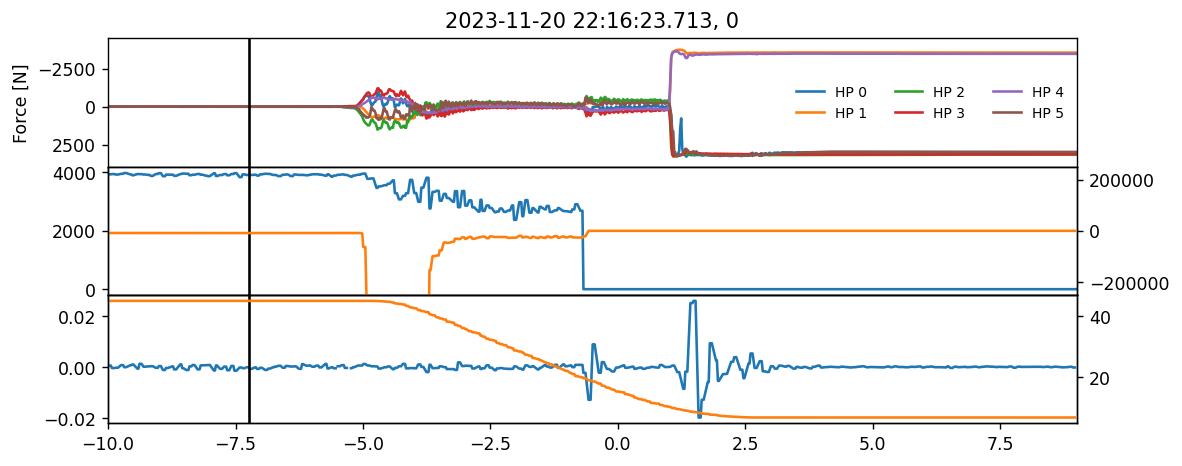

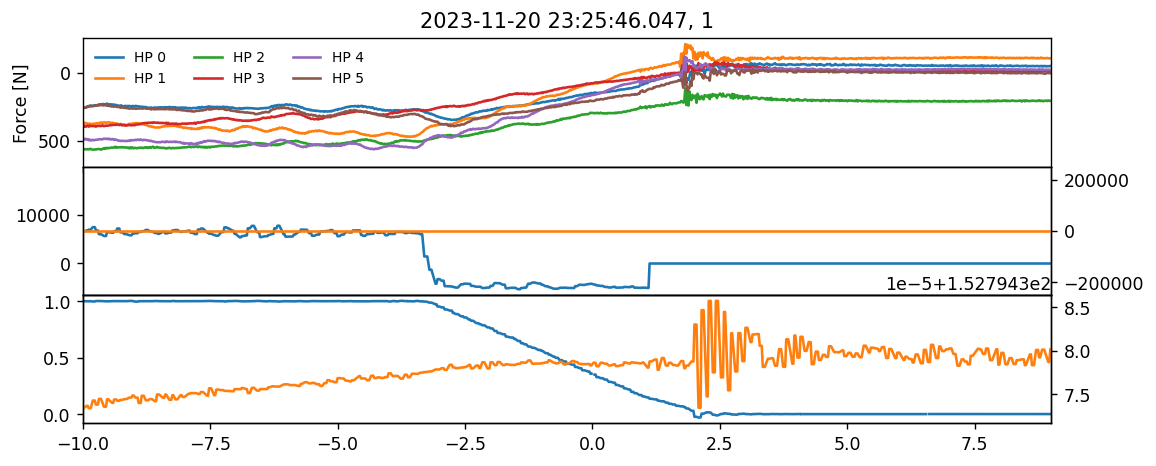

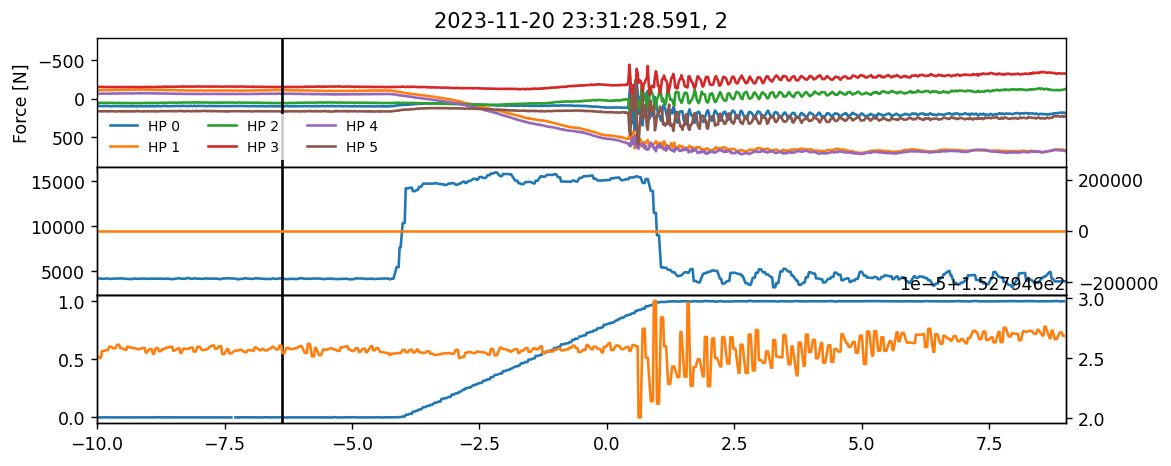

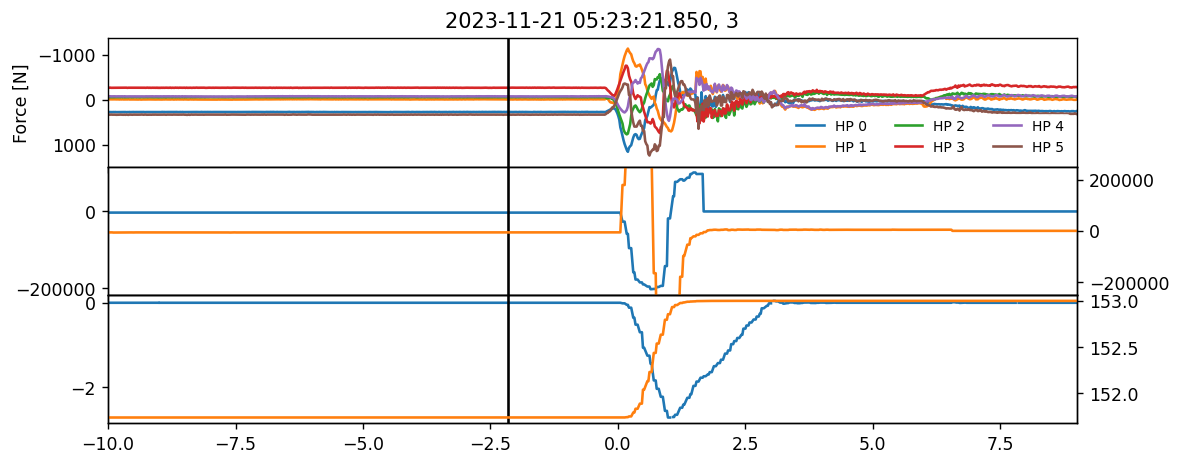

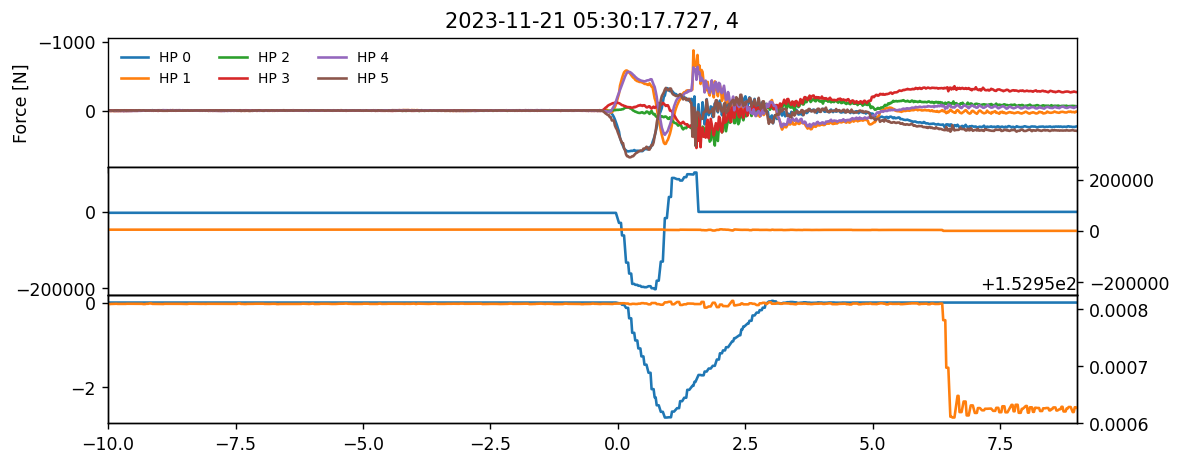

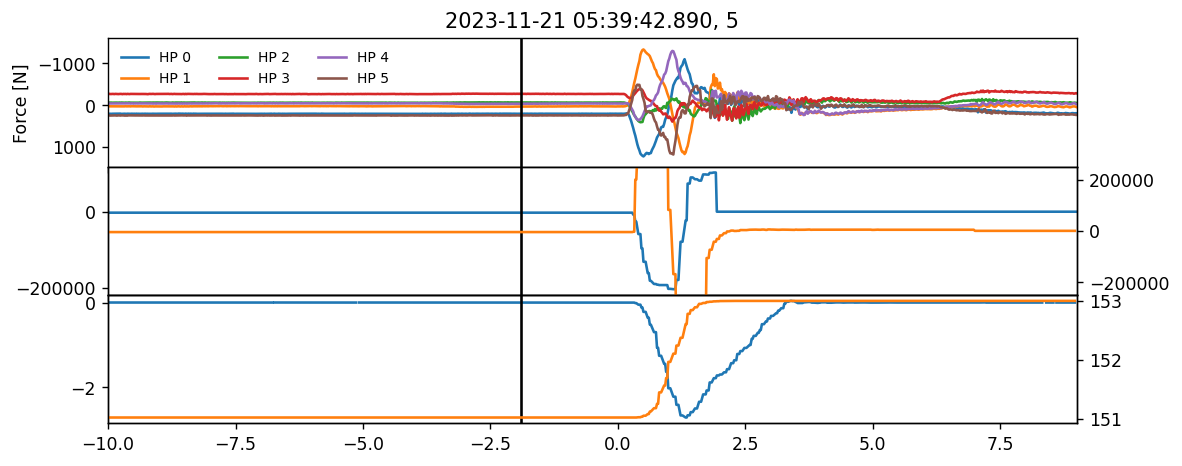

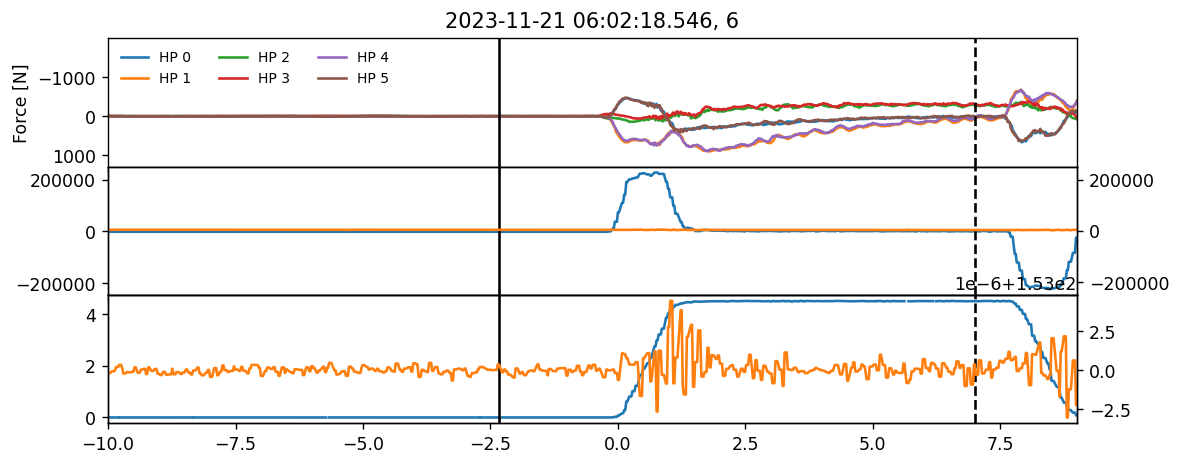

In [143]:
for i in range(len(np.unique(merged_df["event_num"]))):
    
    subframe = merged_df[merged_df["event_num"] == i]
    

    times = Time(subframe["delta_time"], format="unix").datetime
    times = subframe["delta_time"] - 1
    ax.set_title(f'{Time(day_frame.loc[i,"time"], format="unix").iso}, {i}')
    ymax = 0
    ymin = 0
    for fi in range(6):
        ykey = f"measuredForce{fi}"
        ax.plot(times, subframe[ykey], label=f"HP {fi}")
        ymax = max([ymax, 1.2 * subframe[f"measuredForce{fi}"].max()])
        ymin = min([ymin, 1.2 * subframe[f"measuredForce{fi}"].min()])
    ax.legend(ncol=3, edgecolor="None", fontsize=8)

    ax.set(ylim=(ymax, ymin), ylabel="Force [N]")

    ax = axs[1]
    ykey = "actualTorque_mtmount_elevation"
    sel = (~np.isnan(subframe[ykey])) & (abs(subframe["delta_time"]) < 15)
    ax.plot(times[sel], subframe[ykey][sel], label=key)
    sel = (~np.isnan(subframe["actualPosition"])) & (abs(subframe["delta_time"]) < 10)
    ax2 = ax.twinx()
    sel2 = sel & (subframe["delta_time"] > 0)
    ax2.plot(
        times[sel],
        subframe["actualTorque"][sel],  # - subframe["actualTorque"][sel2].median(),
        c="tab:orange",
        label="Azimuth Torque",
    )
    ax2.set(ylim=(-2.5e5, 2.5e5), yscale="linear")
    ax.set_xlim(-10, 9)
    ax = axs[2]
    ax.plot(times[sel], subframe["actualVelocity_mtmount_elevation"][sel], label=key)
    ax2 = ax.twinx()
    sel2 = sel & (subframe["delta_time"] > 0)
    ax2.plot(
        times[sel],
        subframe["actualPosition"][sel],  # - subframe["actualTorque"][sel2].median(),
        c="tab:orange",
        label="Azimuth Torque",
    )

    for slew in slews:
        event_time = Time(day_frame.loc[i, "time"], format="unix")
        if (slew.begin < event_time) & (slew.begin > event_time - 60 * u.s):
            for axis in axs:
                axis.axvline(slew.begin.unix - event_time.unix, c="k")
        if (slew.end > event_time) & (slew.end < event_time + 60 * u.s):
            for axis in axs:
                axis.axvline(slew.end.unix - event_time.unix, c="k", ls="dashed")
                print(slew.end.unix - event_time.unix)
    plt.subplots_adjust(hspace=0)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

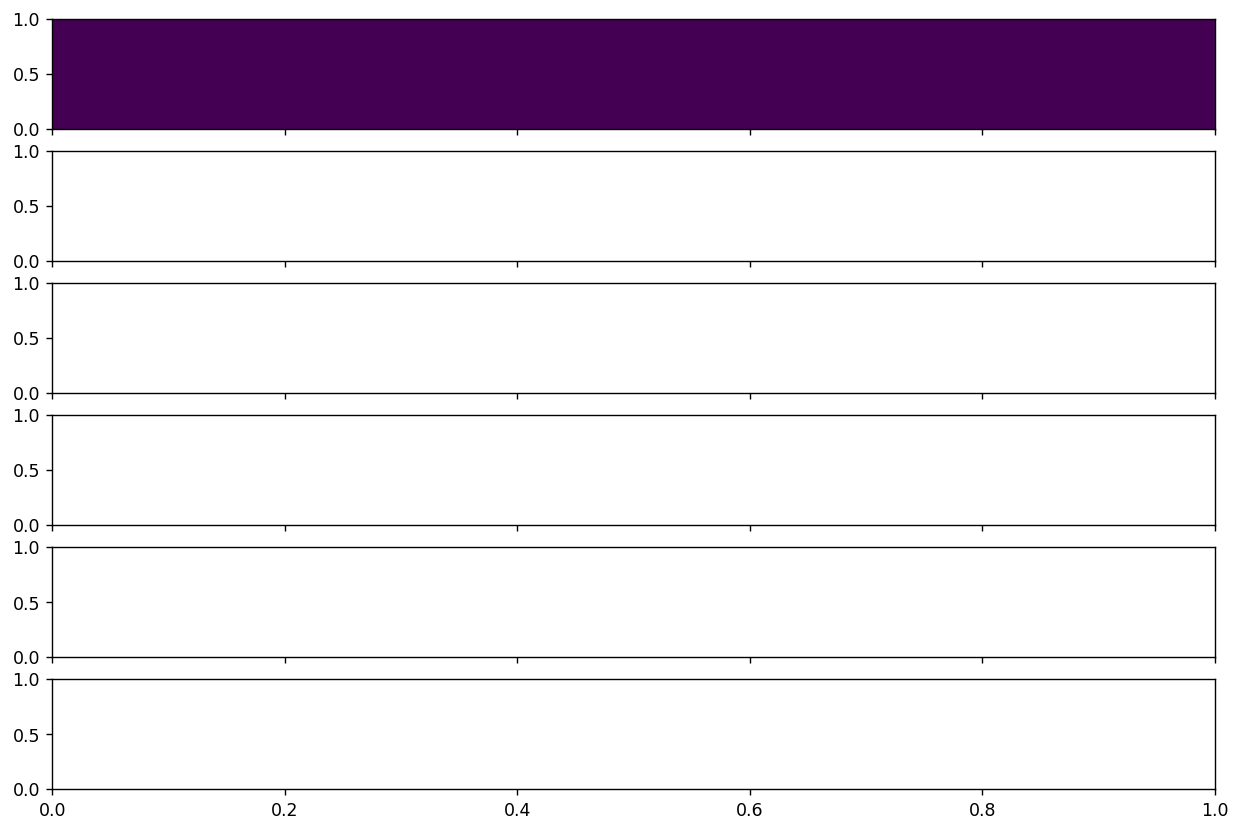

In [74]:
fig, axs=plt.subplots(6,1,dpi=125, figsize=(12,8), sharex=True)
for i,key in enumerate(np.unique(stats_df["key"])[:]):
    sel=(stats_df["key"]==key) & (abs(stats_df["elevation_velocity"]) > 1e-2)
    sel&=(stats_df["elevation_velocity"] > 0) & (stats_df["mean"] > 100)
    ax=axs[i]
    ax.hist2d(Time(stats_df.loc[sel,"time"], format="unix").datetime,
                stats_df.loc[sel,"mean"])#,
                #label=key, s=5)

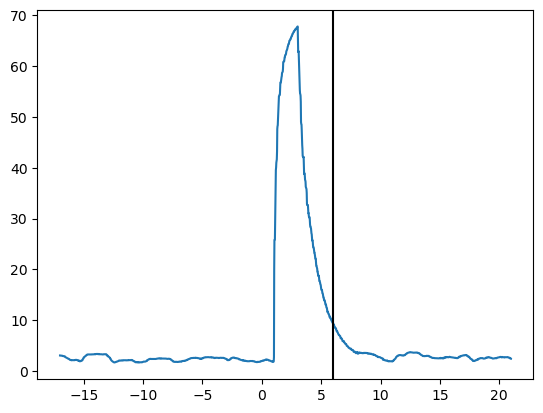

In [79]:
event_num = 0
sel = (merged_df["event_num"] == event_num)
times=Time(merged_df.loc[sel,"snd_timestamp_utc"], format="unix")
plt.plot(merged_df.loc[sel,"delta_time"] , 
            merged_df.loc[sel,"measuredForce2"].rolling(100).std(),
           )
plt.axvline(6, c="k")